### Importing libraries & data.

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
# from sklearn.metrics import r2_score
import numpy as np
import constants

### Importing data
data = pd.read_csv("data/fsigma8_data.dat", sep=';', header=0)

z_data = data['z']
fs8_data = data['fsig8']
fs8_err_plus = data['fsig8_err_plus']
fs8_err_minus = data['fsig8_err_minus']

fs8_err = [fs8_err_plus, fs8_err_minus]
### Do we save the plots ?
SAVEFIG = False

### Plotting growth data.

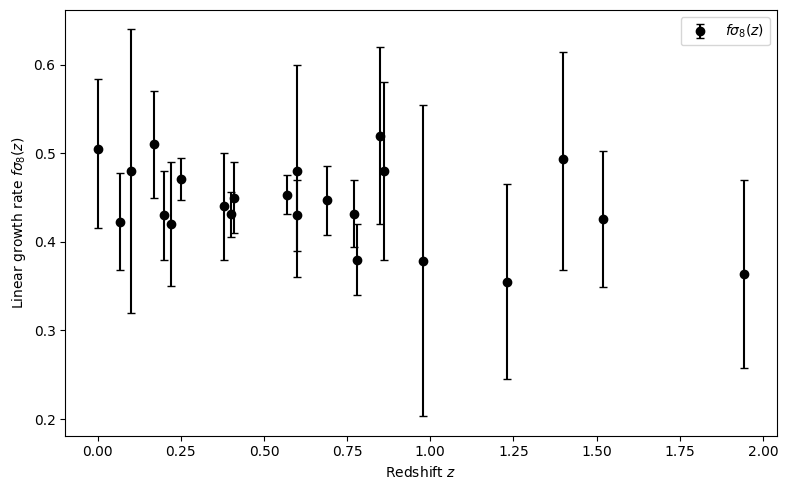

In [ ]:
plt.figure(figsize=(8, 5))

plt.errorbar(z_data, fs8_data, yerr=fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)

plt.xlabel("Redshift $z$")
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$")
plt.grid(False)
plt.legend()

plt.tight_layout()
if SAVEFIG:
    plt.savefig("figure1.png", dpi=300)

plt.show()

### Plotting theoretical linear growth rate with $3\sigma$ bootstrap envelope.

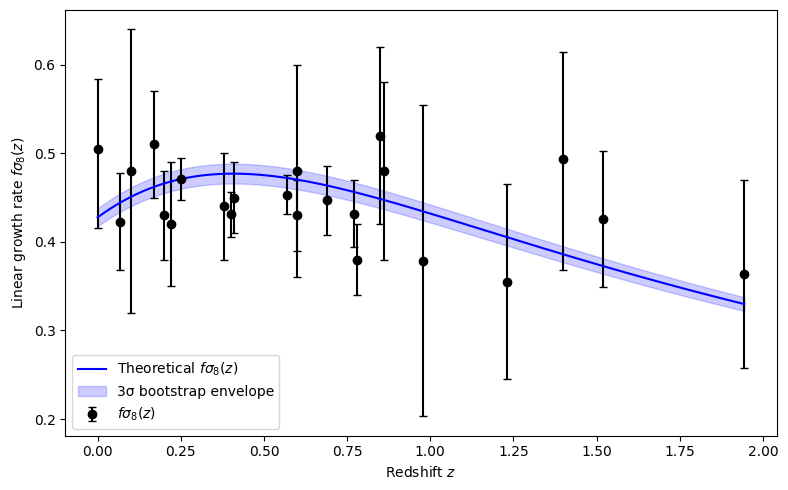

In [99]:
### Defining functions for theoretical calculation
def omega_m(z):
    return constants.OMEGA_0 * (1+z)**3 / (constants.OMEGA_0 * (1+z)**3 + 1 - constants.OMEGA_0)

def g(z, omega_0, omega_l0=0.7):
    omz = omega_m(z)
    olz = 1 - omz
    return 2.5 * omz / (omz**(4/7) - olz + (1 + omz/2)*(1 + olz/70))

def D(z, omega_0, omega_l0=0.7):
    return g(z, omega_0, omega_l0) / g(0, omega_0, omega_l0) / (1 + z)

def gamma(omega_m_z):
    return 6/11 - 15/2057 * np.log(omega_m_z)

def sigma8(z, omega_0, sigma_8_0):
    return sigma_8_0 * D(z, omega_0)

def f(z):
    omega_m_z = omega_m(z)
    return omega_m_z ** gamma(omega_m_z)

def growth(z, omega_0 = constants.OMEGA_0, sigma_8_0 = constants.SIGMA_8_0):
    """returns fσ8(z)

    Args:
        z (float): redshift
    """
    return f(z) * sigma8(z, omega_0, sigma_8_0)


### Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(z_data), max(z_data), nb_points_th)

### Bootstrap
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega_0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma_8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = growth(z_range, omega_0, sigma_8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)


### Plotting
plt.figure(figsize=(8, 5))
# Data distribution
plt.errorbar(z_data, fs8_data, yerr=fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)
# Theoretical function
growth_values = growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
# Enveloppe
plt.fill_between(z_range, fsigma8_mean-3*fsigma8_std, fsigma8_mean+3*fsigma8_std, color='blue', alpha=0.2, label='3σ bootstrap envelope')
# Labels
plt.xlabel("Redshift $z$")
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$")
plt.grid(False)
plt.legend()
plt.tight_layout()

if SAVEFIG:
    plt.savefig("figure2.png", dpi=300)

plt.show()

### Plotting theoretical $f\sigma_8(z)$ and polynomial approximations.

/tmp/ipykernel_3529/1962534676.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('OrRd')  # du jaune au rouge


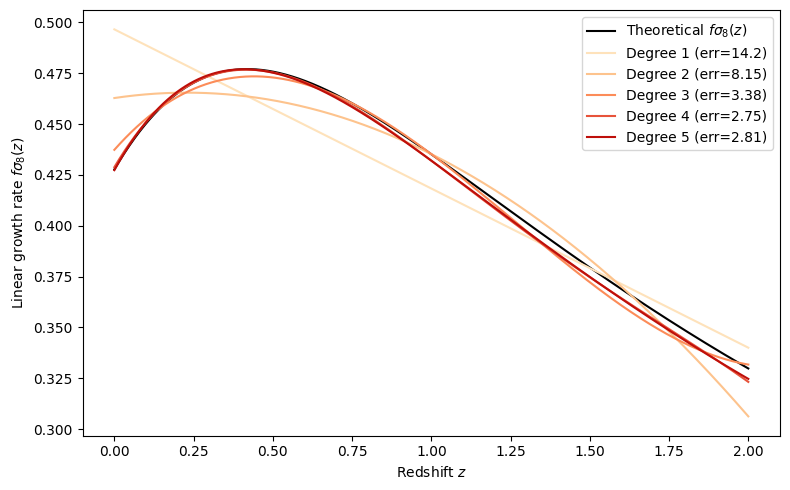

In [149]:
from numpy.polynomial.chebyshev import Chebyshev
from matplotlib import cm
from matplotlib.colors import Normalize

### Max polynomial degree
N = 5
domain = [0, 2]
z_dense = np.linspace(domain[0], domain[1], nb_points_th)
f_dense = growth(z_dense)

plt.figure(figsize=(8, 5))
plt.plot(z_dense, growth_values, color='black', label=r"Theoretical $f\sigma_8(z)$")

### For colors
norm = Normalize(vmin=0, vmax=N+1)
cmap = cm.get_cmap('OrRd')

for n in range(1, N+1):
    cheb_poly = Chebyshev.fit(z_dense, f_dense, deg=n, domain=domain)

    err = 0
    for i in range(nb_points_th):
        err += abs(cheb_poly(z_dense[i]) - growth_values[i])
    
    color = cmap(norm(n))
    plt.plot(z_dense, cheb_poly(z_dense),
             color=color,
             label=f'Degree {n} (err={round(err, 2)})')

plt.xlabel("Redshift $z$")
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

if SAVEFIG:
    plt.savefig("figure3.png", dpi=300)

### Plotting $(\sigma_8, \Omega_m)$ distribution.

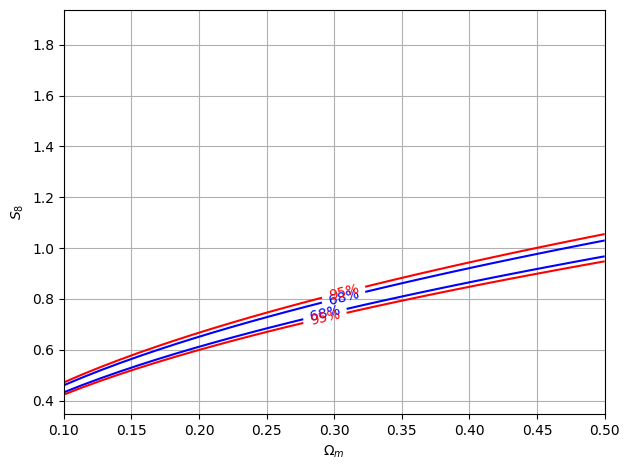

In [165]:
from scipy.stats import chi2

def calc_chi2(omega_0, sigma_8_0):
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    return np.sum((growth(z_data, omega_0, sigma_8_0) - fs8_data)**2 / errors**2)

nb_points_distrib = 30

omega_m_0_list = np.linspace(0.1, 0.5, nb_points_distrib)
sigma8_0_list = np.linspace(0.6, 1.5, nb_points_distrib)

omega_m_0_grid, sigma8_0_grid = np.meshgrid(omega_m_0_list, sigma8_0_list)
chi2_grid = np.zeros_like(omega_m_0_grid)

for i in range(nb_points_distrib):
        for j in range(nb_points_distrib):
            omega_m_0 = omega_m_0_grid[i, j]
            sigma_8_0 = sigma8_0_grid[i, j]
            chi2_grid[i, j] = calc_chi2(omega_0, sigma_8_0)

S8_grid = sigma8_0_grid * np.sqrt(omega_m_0_grid / 0.3)
delta_chi2_grid = chi2_grid - np.min(chi2_grid)

levels = [chi2.ppf(0.683, df=2), chi2.ppf(0.954, df=2)]

# Confidence Contour plot
contour = plt.contour(omega_m_0_grid, S8_grid, delta_chi2_grid, levels=levels,
                        colors=["blue", "red"], linewidths=1.5)
fmt = {}
for l, conf in zip(contour.levels, [68, 95]):
    fmt[l] = f"{conf}%"
plt.clabel(contour, inline=1, fontsize=10, fmt=fmt)

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$S_8$")
plt.grid(True)
plt.tight_layout()

if SAVEFIG:
    plt.savefig("figure4.png", dpi=300)